In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import shutil
import numpy as np
import math
import os

# classes = ('female', 'male')
classes = ('old', 'young')

In [126]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,96,kernel_size=7,stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(96,256,kernel_size=5,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(256,384,kernel_size=3,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.fc1 = nn.Linear(384*6*6,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [127]:
model = Net()
# print(model)
# print("Model's state dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [128]:
def check_acc(model,data_loader):
    num_correct,num_sample = 0, 0
    for images,labels in data_loader:
        images = Variable(images)
        outputs = model(images)
        _,pred = torch.max(outputs.data,1)
        num_sample += labels.size(0)
        num_correct += (pred == labels).sum()
    return float(num_correct)/num_sample

In [129]:
def plot_performance(epoches, train_accs, val_accs, path = 'performance.png'):
    plt.figure()
    plt.plot(np.array(epoches), np.array(train_accs), label = 'training accuracy')
    plt.plot(np.array(epoches), np.array(val_accs), label = 'validation accuracy')
    plt.title('Accuracy on training & validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epoch')
    plt.legend()
    plt.savefig(path)
    
def plot_loss_vs_iterations(losses, path = 'loss.png'):
    plt.figure()
    plt.plot(np.array(losses))
    plt.title('Loss vs. iterations')
    plt.ylabel('Loss')
    plt.xlabel('Number of iterations')
    plt.savefig(path)
    
def save_checkpoint(state, is_best, file_name = 'checkpoint.tar'):
    torch.save(state,file_name)
    if is_best:
        shutil.copyfile(file_name,'model_best.tar')

def load_images(train_root, test_root, train_transform, test_transform):
    '''train_root and test_root are strs'''
    print('Loading images...')
    train_data = datasets.ImageFolder(root=train_root,transform=train_transform)
    test_data = datasets.ImageFolder(root=test_root,transform=test_transform)
    print('Train data length:', len(train_data))
    print('Validate data length:', len(test_data))
    return train_data, test_data

In [130]:
def main():
    train_accs = []
    val_accs = []
    epoches = []
    losses = []
    learning_rate = 0.001
    best_val_acc = 0.0
    batch_size = 64
    num_epochs = 100
    
    train_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.RandomCrop(227),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor()])
    
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor()])

#     root = 'gender-data'
    root = 'age-data'
    train_data_path = os.path.join(root, 'train')
    test_data_path = os.path.join(root, 'test')
    train_data, test_data = load_images(train_data_path, test_data_path, train_transform, test_transform)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False,num_workers=4)

    model = Net()
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        print('Learning Rate: {}'.format(learning_rate))

        for i,(images,labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)
            pred_labels = model(images)
            loss = criterion(pred_labels,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.data.item())
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, math.ceil(len(train_data)/batch_size), loss.data.item()))

        if (epoch + 1) % 5 == 0:
            learning_rate = learning_rate * 0.9
            print('update learning rate:', learning_rate)
            
        if (epoch + 1) % 5 == 0 or epoch + 1 == num_epochs:
            train_acc = check_acc(model,train_loader)
            train_accs.append(train_acc)
            print('Train accuracy for epoch {}: {} '.format(epoch + 1,train_acc))

            val_acc = check_acc(model,test_loader)
            val_accs.append(val_acc)
            print('Validation accuracy for epoch {} : {} '.format(epoch + 1,val_acc))
            
            epoches.append(epoch+1)
            
            is_best = (val_acc > best_val_acc)
            best_val_acc = max(val_acc,best_val_acc)
            save_checkpoint(
                {'epoch':epoch+1,
                 'model_state_dict':model.state_dict(),
                 'best_val_acc':best_val_acc,
                 'optimizer':optimizer.state_dict()}, is_best, file_name = 'checkpoint'+ str(epoch+1) +'.tar')
    
    plot_performance(epoches, train_accs, val_accs)
    plot_loss_vs_iterations(losses)


Loading images...
Train data length: 1058
Validate data length: 83
Starting epoch 1 / 100
Learning Rate: 0.001
Epoch [1/100], Iter [1/17] Loss: 0.6905
Epoch [1/100], Iter [2/17] Loss: 1.3351
Epoch [1/100], Iter [3/17] Loss: 5.8748
Epoch [1/100], Iter [4/17] Loss: 2.3898
Epoch [1/100], Iter [5/17] Loss: 0.6973
Epoch [1/100], Iter [6/17] Loss: 2.3375
Epoch [1/100], Iter [7/17] Loss: 1.5353
Epoch [1/100], Iter [8/17] Loss: 0.8709
Epoch [1/100], Iter [9/17] Loss: 1.0847
Epoch [1/100], Iter [10/17] Loss: 1.2055
Epoch [1/100], Iter [11/17] Loss: 0.9672
Epoch [1/100], Iter [12/17] Loss: 0.7412
Epoch [1/100], Iter [13/17] Loss: 0.7321
Epoch [1/100], Iter [14/17] Loss: 0.7441
Epoch [1/100], Iter [15/17] Loss: 0.6368
Epoch [1/100], Iter [16/17] Loss: 0.7958
Epoch [1/100], Iter [17/17] Loss: 0.7150
Starting epoch 2 / 100
Learning Rate: 0.001
Epoch [2/100], Iter [1/17] Loss: 0.7198
Epoch [2/100], Iter [2/17] Loss: 1.3025
Epoch [2/100], Iter [3/17] Loss: 0.7485
Epoch [2/100], Iter [4/17] Loss: 0.74

Epoch [11/100], Iter [10/17] Loss: 0.4371
Epoch [11/100], Iter [11/17] Loss: 0.5187
Epoch [11/100], Iter [12/17] Loss: 0.4168
Epoch [11/100], Iter [13/17] Loss: 0.4247
Epoch [11/100], Iter [14/17] Loss: 0.3621
Epoch [11/100], Iter [15/17] Loss: 0.5168
Epoch [11/100], Iter [16/17] Loss: 0.4148
Epoch [11/100], Iter [17/17] Loss: 0.5650
Starting epoch 12 / 100
Learning Rate: 0.0008100000000000001
Epoch [12/100], Iter [1/17] Loss: 0.3976
Epoch [12/100], Iter [2/17] Loss: 0.4213
Epoch [12/100], Iter [3/17] Loss: 0.5026
Epoch [12/100], Iter [4/17] Loss: 0.4522
Epoch [12/100], Iter [5/17] Loss: 0.4161
Epoch [12/100], Iter [6/17] Loss: 0.4046
Epoch [12/100], Iter [7/17] Loss: 0.6292
Epoch [12/100], Iter [8/17] Loss: 0.4209
Epoch [12/100], Iter [9/17] Loss: 0.5289
Epoch [12/100], Iter [10/17] Loss: 0.4829
Epoch [12/100], Iter [11/17] Loss: 0.4789
Epoch [12/100], Iter [12/17] Loss: 0.5953
Epoch [12/100], Iter [13/17] Loss: 0.4941
Epoch [12/100], Iter [14/17] Loss: 0.4859
Epoch [12/100], Iter [15

Epoch [22/100], Iter [1/17] Loss: 0.4480
Epoch [22/100], Iter [2/17] Loss: 0.4202
Epoch [22/100], Iter [3/17] Loss: 0.5441
Epoch [22/100], Iter [4/17] Loss: 0.3324
Epoch [22/100], Iter [5/17] Loss: 0.4677
Epoch [22/100], Iter [6/17] Loss: 0.4017
Epoch [22/100], Iter [7/17] Loss: 0.4342
Epoch [22/100], Iter [8/17] Loss: 0.4269
Epoch [22/100], Iter [9/17] Loss: 0.3708
Epoch [22/100], Iter [10/17] Loss: 0.3559
Epoch [22/100], Iter [11/17] Loss: 0.4498
Epoch [22/100], Iter [12/17] Loss: 0.2898
Epoch [22/100], Iter [13/17] Loss: 0.2847
Epoch [22/100], Iter [14/17] Loss: 0.4152
Epoch [22/100], Iter [15/17] Loss: 0.3444
Epoch [22/100], Iter [16/17] Loss: 0.3516
Epoch [22/100], Iter [17/17] Loss: 0.2751
Starting epoch 23 / 100
Learning Rate: 0.0006561000000000001
Epoch [23/100], Iter [1/17] Loss: 0.4805
Epoch [23/100], Iter [2/17] Loss: 0.3893
Epoch [23/100], Iter [3/17] Loss: 0.3268
Epoch [23/100], Iter [4/17] Loss: 0.3624
Epoch [23/100], Iter [5/17] Loss: 0.3471
Epoch [23/100], Iter [6/17] L

Epoch [32/100], Iter [10/17] Loss: 0.3462
Epoch [32/100], Iter [11/17] Loss: 0.2953
Epoch [32/100], Iter [12/17] Loss: 0.2371
Epoch [32/100], Iter [13/17] Loss: 0.4345
Epoch [32/100], Iter [14/17] Loss: 0.2837
Epoch [32/100], Iter [15/17] Loss: 0.2238
Epoch [32/100], Iter [16/17] Loss: 0.2155
Epoch [32/100], Iter [17/17] Loss: 0.2819
Starting epoch 33 / 100
Learning Rate: 0.000531441
Epoch [33/100], Iter [1/17] Loss: 0.3159
Epoch [33/100], Iter [2/17] Loss: 0.3089
Epoch [33/100], Iter [3/17] Loss: 0.3222
Epoch [33/100], Iter [4/17] Loss: 0.3017
Epoch [33/100], Iter [5/17] Loss: 0.2375
Epoch [33/100], Iter [6/17] Loss: 0.2746
Epoch [33/100], Iter [7/17] Loss: 0.2326
Epoch [33/100], Iter [8/17] Loss: 0.3438
Epoch [33/100], Iter [9/17] Loss: 0.2658
Epoch [33/100], Iter [10/17] Loss: 0.2591
Epoch [33/100], Iter [11/17] Loss: 0.1999
Epoch [33/100], Iter [12/17] Loss: 0.2645
Epoch [33/100], Iter [13/17] Loss: 0.2208
Epoch [33/100], Iter [14/17] Loss: 0.1744
Epoch [33/100], Iter [15/17] Loss:

Epoch [43/100], Iter [1/17] Loss: 0.1958
Epoch [43/100], Iter [2/17] Loss: 0.2150
Epoch [43/100], Iter [3/17] Loss: 0.1442
Epoch [43/100], Iter [4/17] Loss: 0.5031
Epoch [43/100], Iter [5/17] Loss: 0.2720
Epoch [43/100], Iter [6/17] Loss: 0.1840
Epoch [43/100], Iter [7/17] Loss: 0.1490
Epoch [43/100], Iter [8/17] Loss: 0.2465
Epoch [43/100], Iter [9/17] Loss: 0.2667
Epoch [43/100], Iter [10/17] Loss: 0.2801
Epoch [43/100], Iter [11/17] Loss: 0.1834
Epoch [43/100], Iter [12/17] Loss: 0.2534
Epoch [43/100], Iter [13/17] Loss: 0.1406
Epoch [43/100], Iter [14/17] Loss: 0.3015
Epoch [43/100], Iter [15/17] Loss: 0.1874
Epoch [43/100], Iter [16/17] Loss: 0.1893
Epoch [43/100], Iter [17/17] Loss: 0.1314
Starting epoch 44 / 100
Learning Rate: 0.00043046721
Epoch [44/100], Iter [1/17] Loss: 0.2088
Epoch [44/100], Iter [2/17] Loss: 0.1274
Epoch [44/100], Iter [3/17] Loss: 0.3321
Epoch [44/100], Iter [4/17] Loss: 0.1007
Epoch [44/100], Iter [5/17] Loss: 0.1356
Epoch [44/100], Iter [6/17] Loss: 0.2

Epoch [53/100], Iter [9/17] Loss: 0.1889
Epoch [53/100], Iter [10/17] Loss: 0.0726
Epoch [53/100], Iter [11/17] Loss: 0.0954
Epoch [53/100], Iter [12/17] Loss: 0.2317
Epoch [53/100], Iter [13/17] Loss: 0.1309
Epoch [53/100], Iter [14/17] Loss: 0.1054
Epoch [53/100], Iter [15/17] Loss: 0.1605
Epoch [53/100], Iter [16/17] Loss: 0.2360
Epoch [53/100], Iter [17/17] Loss: 0.0597
Starting epoch 54 / 100
Learning Rate: 0.0003486784401
Epoch [54/100], Iter [1/17] Loss: 0.1274
Epoch [54/100], Iter [2/17] Loss: 0.1744
Epoch [54/100], Iter [3/17] Loss: 0.0998
Epoch [54/100], Iter [4/17] Loss: 0.1684
Epoch [54/100], Iter [5/17] Loss: 0.0963
Epoch [54/100], Iter [6/17] Loss: 0.0808
Epoch [54/100], Iter [7/17] Loss: 0.1938
Epoch [54/100], Iter [8/17] Loss: 0.1564
Epoch [54/100], Iter [9/17] Loss: 0.0743
Epoch [54/100], Iter [10/17] Loss: 0.1158
Epoch [54/100], Iter [11/17] Loss: 0.1965
Epoch [54/100], Iter [12/17] Loss: 0.2240
Epoch [54/100], Iter [13/17] Loss: 0.1319
Epoch [54/100], Iter [14/17] Lo

Epoch [63/100], Iter [15/17] Loss: 0.1186
Epoch [63/100], Iter [16/17] Loss: 0.0813
Epoch [63/100], Iter [17/17] Loss: 0.1564
Starting epoch 64 / 100
Learning Rate: 0.00028242953648100003
Epoch [64/100], Iter [1/17] Loss: 0.1180
Epoch [64/100], Iter [2/17] Loss: 0.1546
Epoch [64/100], Iter [3/17] Loss: 0.1309
Epoch [64/100], Iter [4/17] Loss: 0.1096
Epoch [64/100], Iter [5/17] Loss: 0.1058
Epoch [64/100], Iter [6/17] Loss: 0.0915
Epoch [64/100], Iter [7/17] Loss: 0.0616
Epoch [64/100], Iter [8/17] Loss: 0.1466
Epoch [64/100], Iter [9/17] Loss: 0.0527
Epoch [64/100], Iter [10/17] Loss: 0.0785
Epoch [64/100], Iter [11/17] Loss: 0.0669
Epoch [64/100], Iter [12/17] Loss: 0.2835
Epoch [64/100], Iter [13/17] Loss: 0.0417
Epoch [64/100], Iter [14/17] Loss: 0.1643
Epoch [64/100], Iter [15/17] Loss: 0.0892
Epoch [64/100], Iter [16/17] Loss: 0.0868
Epoch [64/100], Iter [17/17] Loss: 0.0517
Starting epoch 65 / 100
Learning Rate: 0.00028242953648100003
Epoch [65/100], Iter [1/17] Loss: 0.0575
Epoc

Epoch [74/100], Iter [2/17] Loss: 0.0234
Epoch [74/100], Iter [3/17] Loss: 0.1095
Epoch [74/100], Iter [4/17] Loss: 0.0611
Epoch [74/100], Iter [5/17] Loss: 0.0672
Epoch [74/100], Iter [6/17] Loss: 0.0317
Epoch [74/100], Iter [7/17] Loss: 0.0374
Epoch [74/100], Iter [8/17] Loss: 0.0625
Epoch [74/100], Iter [9/17] Loss: 0.1559
Epoch [74/100], Iter [10/17] Loss: 0.1710
Epoch [74/100], Iter [11/17] Loss: 0.0361
Epoch [74/100], Iter [12/17] Loss: 0.1442
Epoch [74/100], Iter [13/17] Loss: 0.1260
Epoch [74/100], Iter [14/17] Loss: 0.1033
Epoch [74/100], Iter [15/17] Loss: 0.0981
Epoch [74/100], Iter [16/17] Loss: 0.0892
Epoch [74/100], Iter [17/17] Loss: 0.0108
Starting epoch 75 / 100
Learning Rate: 0.00022876792454961005
Epoch [75/100], Iter [1/17] Loss: 0.0718
Epoch [75/100], Iter [2/17] Loss: 0.0576
Epoch [75/100], Iter [3/17] Loss: 0.0460
Epoch [75/100], Iter [4/17] Loss: 0.0163
Epoch [75/100], Iter [5/17] Loss: 0.0995
Epoch [75/100], Iter [6/17] Loss: 0.0177
Epoch [75/100], Iter [7/17] 

Epoch [84/100], Iter [8/17] Loss: 0.1184
Epoch [84/100], Iter [9/17] Loss: 0.0223
Epoch [84/100], Iter [10/17] Loss: 0.0797
Epoch [84/100], Iter [11/17] Loss: 0.0395
Epoch [84/100], Iter [12/17] Loss: 0.1177
Epoch [84/100], Iter [13/17] Loss: 0.0783
Epoch [84/100], Iter [14/17] Loss: 0.0155
Epoch [84/100], Iter [15/17] Loss: 0.0471
Epoch [84/100], Iter [16/17] Loss: 0.0104
Epoch [84/100], Iter [17/17] Loss: 0.0099
Starting epoch 85 / 100
Learning Rate: 0.00018530201888518417
Epoch [85/100], Iter [1/17] Loss: 0.0736
Epoch [85/100], Iter [2/17] Loss: 0.0158
Epoch [85/100], Iter [3/17] Loss: 0.0155
Epoch [85/100], Iter [4/17] Loss: 0.0668
Epoch [85/100], Iter [5/17] Loss: 0.0495
Epoch [85/100], Iter [6/17] Loss: 0.0920
Epoch [85/100], Iter [7/17] Loss: 0.0404
Epoch [85/100], Iter [8/17] Loss: 0.2582
Epoch [85/100], Iter [9/17] Loss: 0.0670
Epoch [85/100], Iter [10/17] Loss: 0.0164
Epoch [85/100], Iter [11/17] Loss: 0.0891
Epoch [85/100], Iter [12/17] Loss: 0.1159
Epoch [85/100], Iter [13/

Epoch [94/100], Iter [14/17] Loss: 0.0591
Epoch [94/100], Iter [15/17] Loss: 0.0509
Epoch [94/100], Iter [16/17] Loss: 0.0587
Epoch [94/100], Iter [17/17] Loss: 0.0122
Starting epoch 95 / 100
Learning Rate: 0.0001500946352969992
Epoch [95/100], Iter [1/17] Loss: 0.1036
Epoch [95/100], Iter [2/17] Loss: 0.0502
Epoch [95/100], Iter [3/17] Loss: 0.0098
Epoch [95/100], Iter [4/17] Loss: 0.0062
Epoch [95/100], Iter [5/17] Loss: 0.0327
Epoch [95/100], Iter [6/17] Loss: 0.0365
Epoch [95/100], Iter [7/17] Loss: 0.0042
Epoch [95/100], Iter [8/17] Loss: 0.0164
Epoch [95/100], Iter [9/17] Loss: 0.0505
Epoch [95/100], Iter [10/17] Loss: 0.0049
Epoch [95/100], Iter [11/17] Loss: 0.0079
Epoch [95/100], Iter [12/17] Loss: 0.0237
Epoch [95/100], Iter [13/17] Loss: 0.0603
Epoch [95/100], Iter [14/17] Loss: 0.0054
Epoch [95/100], Iter [15/17] Loss: 0.0257
Epoch [95/100], Iter [16/17] Loss: 0.0086
Epoch [95/100], Iter [17/17] Loss: 0.0088
update learning rate: 0.0001350851717672993
Train accuracy for epo

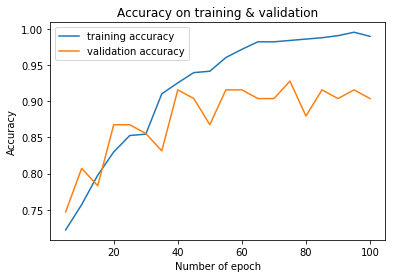

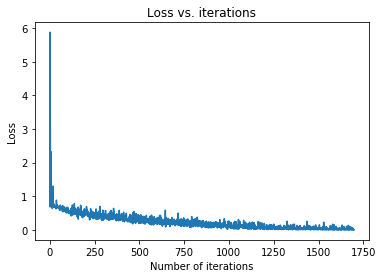

In [131]:
main()

In [136]:
train_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.RandomCrop(227),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()])
    
test_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(227),
     transforms.ToTensor()])

# root = 'gender-data'
root = 'age-data'
train_data_path = os.path.join(root, 'train')
test_data_path = os.path.join(root, 'test')
train_data, test_data = load_images(train_data_path, test_data_path, train_transform, test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20,shuffle=True,num_workers=4)

Loading images...
Train data length: 1058
Validate data length: 83


In [137]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [138]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(os.path.join('','model_best.tar'))
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

optimizer.load_state_dict(checkpoint['optimizer'])

model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=13824, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3):

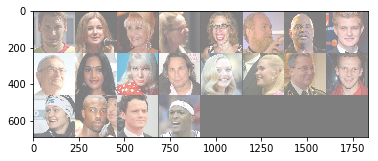

GroundTruth:  young young   old   old   old   old   old young   old young young   old young young   old young young young young young
##Predicted:  young young   old   old   old   old   old young   old young young   old young young   old young young young young young


In [139]:
# GroundTruth
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(20)))

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('##Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(20)))